d:\codes_uni\ml\game_detection\datareader\dataset.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return tensor(img).clone().detach().to(torch.float), tensor(y).clone().detach().to(torch.float)


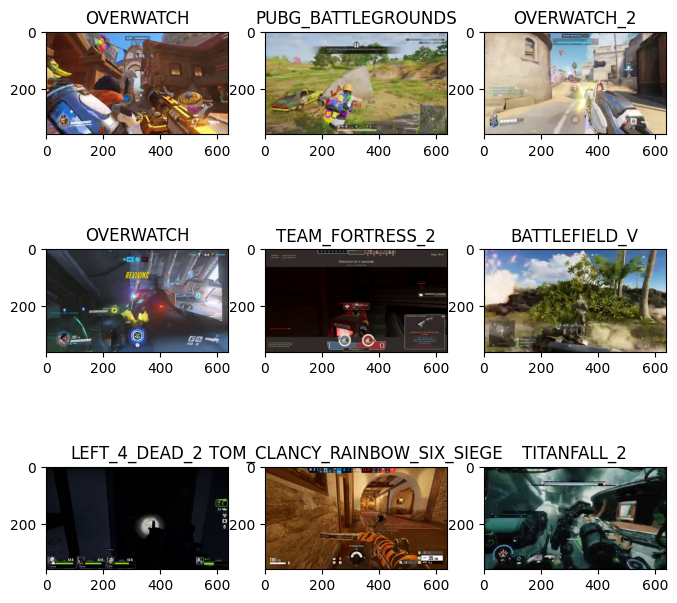

In [1]:
from datareader.dataset import GameScreenShotDataset
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# autoreload
%load_ext autoreload
%autoreload 2

transform = transforms.Compose([
    transforms.Resize((360, 640)),
    transforms.ToTensor()
])

batch_size = 32
train_dataset = GameScreenShotDataset(root='./dataset/processed/train', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataset = GameScreenShotDataset(root='./dataset/processed/val', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)
test_dataset = GameScreenShotDataset(root='./dataset/processed/test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    
    label_id = int(label.argmax().item())
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label_id])
    plt.imshow(img.numpy().transpose(1,2,0))
plt.show()


In [2]:
from torchvision.models import resnet18, ResNet18_Weights
from torch import nn
from tqdm import tqdm


# Training script
def train_model(model, dataloader, loss_fn, optimizer, epochs=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    for i in range(0, epochs):
        model.train()
        
        running_loss = 0.0
        epoch_loss = 0.0
        
        # Train
        for i, batch in tqdm(enumerate(dataloader),unit="batch",total=len(dataloader)):
            X, y = batch
            X, y = X.float().to(device), y.float().to(device)
            # print(X.shape, y.shape)
            
            optimizer.zero_grad()
            
            pred = model(X)
            
            loss = loss_fn(pred,y)
            running_loss += loss.item()
            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            # print progress
            if i % 5000 == 0:
                print(f"Epoch {i+1}, loss: {running_loss/100}")
                running_loss = 0.0
            
        print(f"Epoch {i+1}, loss: {epoch_loss/len(train_dataloader)}")
        epoch_loss = 0.0
        
        # Validate
        test_model(model, val_dataloader, loss_fn, optimizer)
        
# Validate script
def test_model(model, dataloader, loss_fn, optimizer):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    
    correct = 0
    total = 0
    loss = 0

    with torch.no_grad():
        for i, batch in val_dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            print(X.shape, y.shape)
            
            pred = model(X)
            
            _, predicted = torch.max(pred, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            loss += loss_fn(pred, y).item()
            
    print(f"Accuracy: {correct/total}")
    print(f"Average loss: {loss/total}")


In [3]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 30)
# print(model)

c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kana_\.conda\envs\taiko-ai\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
# model = resnet18(pretrained=False)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = loss_fn = nn.CrossEntropyLoss()

train_model(model, train_dataloader, loss_func, optimizer, epochs=10)


  0%|          | 0/2813 [00:00<?, ?batch/s]

torch.Size([32, 3, 360, 640]) torch.Size([32, 30])


  0%|          | 1/2813 [01:17<60:24:11, 77.33s/batch]

Epoch 1, loss: 0.034838933944702145
torch.Size([32, 3, 360, 640]) torch.Size([32, 30])


  0%|          | 2/2813 [02:01<45:04:08, 57.72s/batch]